we import some clmm modules

In [1]:
import sys
import os
import clmm
from itertools import combinations, chain
import healpy
import clmm.dataops
from clmm.dataops import compute_tangential_and_cross_components, make_radial_profile, make_bins
from clmm.galaxycluster import GalaxyCluster
import clmm.utils as u
from clmm import Cosmology
from clmm.support import mock_data as mock
cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
import numpy as np
cosmo_clmm = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table
from numpy import random
import chainconsumer
import scipy

clmm.__version__

'0.9.2'

we import `clmm` module's core.

modules

In [2]:
import matplotlib.pyplot as plt
import astropy.units as u
import numpy as np
from scipy.optimize import curve_fit

we define `astropy` and `ccl` cosmology object

In [3]:
mock_cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)

In [4]:
moo = clmm.Modeling(massdef = 'critical', delta_mdef = 200, halo_profile_model = 'nfw')
moo.set_cosmo(mock_cosmo)

we define the `Modeling` object `moo` to model the galaxy cluster.

In [5]:
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]

# Estimator of the stacked excess surface density

- The maximum likelihood estimator of the excess surface density in the radial bin $[R, R + \Delta R[$ is defined by

$$\widehat{\Delta\Sigma}_+(R) = \frac{1}{\sum\limits_{l,s = 1} w_{ls}}
     \sum\limits_{l,s= 1}w_{ls}\langle\Sigma_{{\rm crit}}(z_s, z_l)^{-1}\rangle^{-1}\epsilon_+^{s},$$ where $\epsilon_+^{s}$ is the tangential ellipticity of the background galaxy with index $s$ (as source) relative to the dark matter halo position with index $l$ (as lens).
     
- The critical surface mass density expresses as $\Sigma_{{\rm crit}}(z_s, z_l) = \frac{c^2}{4 \pi G} \frac{D_A(z_s)}{D_A(z_l) D_A(z_s, z_l)}$, where $D_A(z_l), D_A(z_s)$ are respectively the angular diameter distance to the lens and to the source in physical units, and $D_A(z_s, z_l)$ is the angular diameter distance between the lens and the source.


- The average $\langle\Sigma_{\rm crit}(z_s,z_l)^{-1}\rangle$ is defined as $\langle\Sigma_{\rm crit}(z_s,z_l)^{-1}\rangle = \int_{z_l + \delta}^{+\infty} d z_s\ p_{\rm photoz,s}(z_s)\ \Sigma_{\rm crit}(z_s,z_l)^{-1}$, where $p_{\rm photoz,s}$ is the photometric probability density function for the background galaxy with index $s$.

This equation can be re-written as

$$\widehat{\Delta\Sigma}_+(R) = \frac{1}{\sum\limits_{l = 1} W_{l}}
     \sum\limits_{l,s= 1}W_{l}\Delta\Sigma_l(R)$$
     
where $$\Delta\Sigma_l(R) = \frac{1}{\sum\limits_{s = 1} w_{ls}}
     \sum\limits_{s= 1}w_{ls}\langle\Sigma_{{\rm crit}}(z_s, z_l)^{-1}\rangle^{-1}\epsilon_+^{s}$$
     
and $$W_{l} = \sum\limits_{s= 1}w_{ls}$$

The quantities $w_{s}$ are the weights that maximise the sigmnal-to-noise ratio of the excess surface density estimator. They downweight the galaxies that are close in redshift to the cluster (where the lensing signal is weak). They include the lack of informations on both redshift and shape reconstruction for each background galaxies. 

- In the case where there is no error on the shape measurement (for the purpose of cosmoDC2 galaxies), the weight writes $w_{ls} = \langle\Sigma_{\rm crit}(z_s,z_l)^{-1}\rangle^{2}$,

- In the case of true redshift $z_s$, the PDF reduces to a Dirac function centered at $z_s$, giving the average $\langle\Sigma_{\rm crit}(z_l,z_s)^{-1}\rangle = \Sigma_{\rm crit}(z_l,z_s)^{-1} $ and the weight $w_{s} = \Sigma_{\rm crit}(z_s,z_l)^{-2}$,

We now define some redshift interval and input mass interval to select GalaxyCluster objects

# Dark matter halo catalog for the stack

In [6]:
z_bin = [0.2,0.25]
logm_bin = [14, 14.1] #Solar Mass
logm_bin = np.array(logm_bin)
n_catalogs = 50
ngals = 10000

we define a set of selected cluster with given true masses ans true redshifts

In [7]:
cluster_m = 10**((logm_bin[1] - logm_bin[0])*np.random.random(n_catalogs) + logm_bin[0]) #in M_sun
cluster_z = (z_bin[1] - z_bin[0])*np.random.random(n_catalogs) + z_bin[0]
lnc = abs(np.log(4) + 0.1*np.random.randn(n_catalogs))
concentration = np.exp(lnc)
#generate random position on the sky
ra = np.random.random(n_catalogs)*(360 + 0) - 0 #from 0 to 360 deg
sindec = np.random.random(n_catalogs)*(1 + 1) - 1
dec = np.arcsin(sindec)*180/np.pi #from -90 to 90 deg

Text(0.5, 1.0, '2D map')

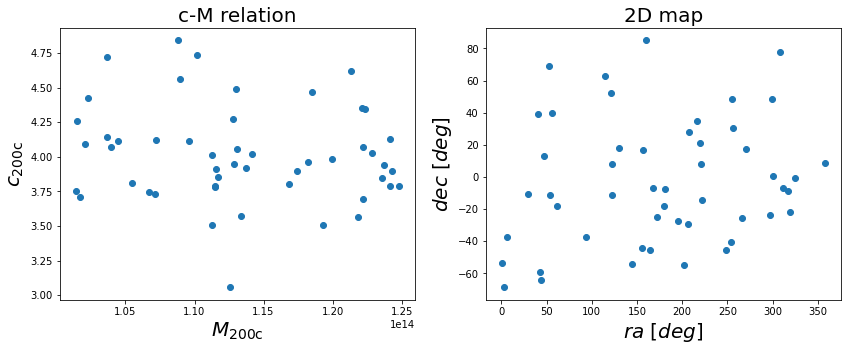

In [8]:
fig, ax = plt.subplots(1,2, figsize = (14,5))
ax[0].scatter(cluster_m, concentration)
ax[0].set_xlabel(r'$M_{\rm 200c}$', fontsize = 20)
ax[0].set_ylabel(r'$c_{\rm 200c}$', fontsize = 20)
ax[0].set_title('c-M relation', fontsize = 20)
ax[1].scatter(ra, dec)
ax[1].set_xlabel(r'$ra\ [deg]$', fontsize = 20)
ax[1].set_ylabel(r'$dec\ [deg]$', fontsize = 20)
ax[1].set_title('2D map', fontsize = 20)

We choose a given shapenoise for background galaxy shapes

In [9]:
shapenoise = 0.005

In [10]:
def excess_surface_density(single_catalog = None, radial_bin = None, sigma_c = None):
    r"""
    Attributes:
    -----------
    
    single_catalog : GalaxyCluster object
    
    radial_bin : liste
        radial bins to evaluate the binned excess surface density
    
    sigma_c : string 
        column name in the single_catalog for the critical surface mass density
        
    Returns:
    --------
    
    ds, r, sum_weights : array, array, array
        the binned excess surface density, the binned radius, the sum of weights w_ls in each radial bin

    """
    
    ds = np.zeros(len(radial_bin))
    
    r = np.zeros(len(radial_bin))
    
    sum_weights = np.zeros(len(radial_bin))
    
    n_gal_per_bin = np.zeros(len(radial_bin))
    
    for i, r_bin in enumerate(radial_bin):

        mask = (single_catalog.galcat['R'] > r_bin[0])*(single_catalog.galcat['R'] < r_bin[1])
        
        w_ls = 1./single_catalog.galcat[sigma_c][mask]**2
        
        ds[i] = np.average(single_catalog.galcat['et'][mask]*single_catalog.galcat[sigma_c][mask], weights = w_ls)
        
        r[i] = np.average(single_catalog.galcat['R'][mask])
        
        n_gal_per_bin[i] = len(mask[mask == True])
        
        sum_weights[i] = np.sum( w_ls )
        
    return ds, r, sum_weights, n_gal_per_bin

## Generating background galaxy catalogs & estimating individual shear profile

We use `clmm` to generate `n_catalogs` background galaxy catalogs for each clusters in the sample. We estimate the individual shear profile and store the individual data:

- `ds_single`, `r_single` the single excess surface density extimated in the radial bins, and the average radius in each radial bins
- `W_l` the sum of the weight `w_ls` for each lens-source pairs in each radial bins. Here, we consider true redshifts of background galaxies.

In [11]:
add_photoz_weights = False

In [ ]:
%time
GalaxyCluster_list = []

for i in range(n_catalogs):
    
    if i%10 == 0: print(i)
    
    noisy_data_z = mock.generate_galaxy_catalog(cluster_m[i], cluster_z[i], concentration[i], 
                                                cosmo, 
                                                zsrc = 'chang13', 
                                                Delta_SO=200, 
                                                massdef='critical',
                                                halo_profile_model='nfw', 
                                                zsrc_min=cluster_z[i] + 0.1,
                                                zsrc_max=3., 
                                                field_size=10., 
                                                shapenoise=shapenoise, 
                                                photoz_sigma_unscaled=0.05, 
                                                ngals=ngals)
    
    if add_photoz_weights == True:
        
        pzbins_constant = np.linspace(0,3,30)
        
        sigma_crit_1 = 1./mock_cosmo.eval_sigma_crit(cluster_z[i], pzbins_constant)

        photoz_matrix = np.zeros([len(noisy_data_z), len(pzbins_constant)])
        
        r"""
        I added this line since the photoz pdf is not computed on a constant redshift grid. simps integral can be optimized using the same x-axis for multiple integrals.
        =================================================================================================================================================================
        """

        for f in range(len(noisy_data_z['id'])):

            photoz_matrix[f,:] = np.interp(pzbins_constant, noisy_data_z['pzbins'][f], noisy_data_z['pzpdf'][f])
            
        r"""
        =================================================================================================================================================================
        """

        unormed_integral = scipy.integrate.simps(photoz_matrix * sigma_crit_1, x = pzbins_constant, axis = 1)

        norm = scipy.integrate.simps(photoz_matrix, x = pzbins_constant, axis = 1)

        noisy_data_z['sigma_c_photoz'] = (unormed_integral/norm)**(-1)
        
    
    cl = clmm.GalaxyCluster('mock_cluster', 0, 0, cluster_z[i], noisy_data_z)
    
    cl.compute_tangential_and_cross_components(geometry="flat",
                                              shape_component1='e1', shape_component2='e2', 
                                              tan_component='et', cross_component='ex',
                                              add=True, 
                                              is_deltasigma = False, 
                                              cosmo = cosmo)
    
    cl.galcat['R'] = mock_cosmo.eval_da_z1z2(0,cluster_z[i])*cl.galcat['theta']
    
    ang, phi = clmm.dataops._compute_lensing_angles_flatsky(cl.ra, cl.dec, cl.galcat['ra'], cl.galcat['dec'])

    cl.galcat['phi'] = np.array(phi)
    
    cl.galcat['sigma_c_true'] = mock_cosmo.eval_sigma_crit(cluster_z[i], cl.galcat['ztrue'])
    
    GalaxyCluster_list.append(cl)

CPU times: user 6 µs, sys: 4 µs, total: 10 µs
Wall time: 20 µs
0


/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/numpy/ma/core.py:2832: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  order=order, subok=True, ndmin=ndmin)
/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/clmm-0.9.2-py3.7.egg/clmm/theory/func_layer.py:347: UserWarning: Some source redshifts are lower than the cluster redshift. kappa = 0 for those galaxies.


# Stacked profile
$$\widehat{\Delta\Sigma}_+(R) = \frac{1}{\sum\limits_{l = 1} W_{l}}
     \sum\limits_{l= 1}W_{l}\Delta\Sigma_l(R)$$

In [ ]:
new_bins = np.logspace(np.log10(0.3), np.log10(5), 20)
radial_bin = [[new_bins[s],new_bins[s+1]] for s in range(len(new_bins)-1)]

In [ ]:
names = ['ds_single', 'r_single', 'W_l', 'N_gal_per_bin', 'c', 'z', 'mass', 'ra', 'dec']

Stack_file_true = {name : [] for name in names}

for i in range(n_catalogs):
    
    ds_single, r_single, sum_weights_single, N_gal_per_bin = excess_surface_density(single_catalog = GalaxyCluster_list[i], radial_bin = radial_bin, sigma_c = 'sigma_c_true')
    
    data_to_store = [ds_single, r_single, sum_weights_single, N_gal_per_bin, concentration[i], cluster_z[i], cluster_m[i], ra[i], dec[i]]
    
    for d, name in enumerate(names):
        
        Stack_file_true[name].append(data_to_store[d])

We estimate the mean excess surface density profile `ds_mean` and the mean radius `r_mean`

In [ ]:
#stacked excess surface density profile - true redshift case

ds_mean_true = np.average(Stack_file_true['ds_single'], weights = Stack_file_true['W_l'], axis = 0)
r_mean_true = np.average(Stack_file_true['r_single'], weights = None, axis = 0)

# Covariance matrix for stacked analysis
## Sample covariance matrix

We compute the sample covariance matrix defined as
$$
    (\mathbf{C}^{\rm sample})_{i,j} = \frac{1}{N_{\rm cluster} - 1}\sum_{k = 0}^{N_{\rm cluster}}[\Delta\Sigma^k(R_i) - \overline{\Delta\Sigma}(R_i)] [\Delta\Sigma^k(R_j) - \overline{\Delta\Sigma}(R_j)],
$$
and $\overline{\Delta\Sigma}(R_i)$ is denoted by
$$
    \overline{\Delta\Sigma}(R_i) = \frac{1}{N_{\rm cluster}}\sum_{k = 0}^{N_{\rm cluster}} \Delta\Sigma^k(R_i).
$$

In [ ]:
sample_covariance_stack_true = np.cov(np.array(Stack_file_true['ds_single']).T)/n_catalogs

## Jackknife covariance matrix
We also estimate the covariance matrix by the delete-1 Jackknife method : We split the full sky area arroundin $N_{\rm JK}$ regions, and we exclude one region at a time and re-estimate the stacked excess surface density profile:, the covariance writes

$$
    (\mathbf{C}^{\rm JK})_{i,j} = \frac{N_{\rm JK} - 1}{N_{\rm JK}}\sum_{k = 0}^{N_{\rm JK}}[\Delta\Sigma^k(R_i) - \overline{\Delta\Sigma}(R_i)] [\Delta\Sigma^k(R_j) - \overline{\Delta\Sigma}(R_j)]
$$
with the mean 
$$
    \overline{\Delta\Sigma}(R_i) = \frac{1}{N_{\rm JK}}\sum_{k = 0}^{N_{\rm JK}} \Delta\Sigma^k(R_i).
$$
For this example, we use the sky sub-division of the 3D sphere according to the healpix pixelisation (package `healpy`). It depends on the parameter `n_side`, leading to a sky area divided in `12*n_side**2` sub-regions.

In [ ]:
def stack_jackknife_covariance_matrix(file, ra_colname, dec_colname, n_side, N_delete):
    
        r"""
        Attributes:
        -----------
        file : dictionary, astropy Table
            file with the individual excess surface density profiles
        ra_colname, dec_colname : string, string
            names of the columns in the dictionnary that corresponds to the ra and dec coordinates
        n_side : int (2, 4, 8)
            parameter for the healpix pixel sub-division of the 3D sphere
        N_delete : int
            number of removed regions for each realization (delete-d jackknife method)
        Returns:
        --------
        cov : array
            Jackknife delete-d covariance matrix
        """
    
        ra, dec =  file[ra_colname], file[dec_colname]
        
        index = np.arange(len(ra))

        healpix = healpy.ang2pix(2**n_side, ra, dec, nest=True, lonlat=True)
        
        healpix_list_unique = np.unique(healpix)
        
        #for h in healpix_list_unique: plt.scatter(np.array(ra)[healpix == h], np.array(dec)[healpix == h])
        
        healpix_combination_delete = list(combinations(healpix_list_unique, N_delete))

        data_jack = []

        for i, hp_list_delete in enumerate(healpix_combination_delete):

                mask_in_area = np.isin(healpix, hp_list_delete)

                mask_out_area = np.invert(mask_in_area)

                file_jackknife = Table(file)[mask_out_area]
                
                ds_mean_jackknife = np.average(file_jackknife['ds_single'], weights = file_jackknife['W_l'], axis = 0)
                
                data_jack.append(ds_mean_jackknife)

        data_jack = np.array(data_jack)

        N = np.stack((data_jack.astype(float)), axis = 1)
        
        n_jack = len(healpix_combination_delete)

        cov_N = (n_jack - 1) * np.cov(N, bias = False, ddof=0)

        coeff = (n_jack-N_delete)/(N_delete*n_jack)
        
        return cov_N * coeff

In [ ]:
n_side = 2
n_jack = 12*n_side**2
jackknife_covariance_stack_true = stack_jackknife_covariance_matrix(Stack_file_true,  'ra', 'dec', n_side, 1)

## Bootstrap covariance matrix
We also estimate the covariance matrix by the bootstrap method : we create $N_{\rm boot}$ resamplings of the cluster stack, with the same number of clusters but by taking them by random sampling with replacement.

$$
    (\mathbf{C}^{\rm boot})_{i,j} = \frac{1}{N_{\rm boot}-1}\sum_{k = 0}^{N_{\rm boot}}[\Delta\Sigma^k(R_i) - \overline{\Delta\Sigma}(R_i)] [\Delta\Sigma^k(R_j) - \overline{\Delta\Sigma}(R_j)]
$$
with the mean 
$$
    \overline{\Delta\Sigma}(R_i) = \frac{1}{N_{\rm boot}}\sum_{k = 0}^{N_{\rm boot}} \Delta\Sigma^k(R_i).
$$

In [ ]:
def stack_bootstrap_covariance_matrix(file, n_boot):
    
        r"""
        Attributes:
        -----------
        file : dictionary, astropy Table
            file with the individual excess surface density profiles
        n_boot : int
            number of bootstrap resampling resampling
        Returns:
        --------
        cov : array
            Jackknife delete-d covariance matrix
        """
        
        index_halos = np.arange(len(file['ra']))
                                
        data_bootstrap = []

        for i in range(n_boot):

                index_bootstrap = np.random.choice(index_halos, len(file['ra']))
                
                file_bootstrap = Table(file)[index_bootstrap]
                
                ds_mean_bootstrap = np.average(file_bootstrap['ds_single'], weights = file_bootstrap['W_l'], axis = 0)
                
                data_bootstrap.append(ds_mean_bootstrap)

        data_bootstrap = np.array(data_bootstrap)

        N = np.stack((data_bootstrap.astype(float)), axis = 1)
        
        cov_N = np.cov(N, bias = False,ddof=0)
        
        return cov_N

In [ ]:
#covariance matrix
n_boot = 200
bootstrap_covariance_stack_true = stack_bootstrap_covariance_matrix( Stack_file_true, n_boot)

# Covariance matrix for single cluster analysis
For the single cluster analysis, we use the background galaxy catalog of one random cluster in our sample.
## Jackknife covariance matrix
We estimate the single excess surface density covariance matrix by the delete-1 Jackknife method : We split the sky area arround the cluster center in $N_{\rm JK}$ regions, and we exclude one region at a time and re-estimate the excess surface density profile:, the covariance writes

$$
    (\mathbf{C}^{\rm JK})_{i,j} = \frac{N_{\rm JK} - 1}{N_{\rm JK}}\sum_{k = 0}^{N_{\rm JK}}[\Delta\Sigma^k(R_i) - \overline{\Delta\Sigma}(R_i)] [\Delta\Sigma^k(R_j) - \overline{\Delta\Sigma}(R_j)]
$$
with the mean 
$$
    \overline{\Delta\Sigma}(R_i) = \frac{1}{N_{\rm JK}}\sum_{k = 0}^{N_{\rm JK}} \Delta\Sigma^k(R_i).
$$

In [ ]:
def single_jackknife_covariance_matrix(single_catalog = None, N_jk = None):
    
    r"""
    Attributes:
    -----------
    single_catalog : GalaxyCluster object
        GalaxyCluster object of a single cluster 
    N_jk : int
        number of jackknife regions
        
    Returns:
    --------
    cov : array
        Jackknife delete-1 covariance matrix
    
    """
    
    phi = np.linspace(-np.pi, np.pi, N_jk + 1)
    
    phi_bin = binning(phi)
    
    gt = []
    
    mask_list_in = [(phi_[0] < single_catalog.galcat['phi'])*(single_catalog.galcat['phi'] < phi_[1]) for phi_ in phi_bin]
    
    for s, phi_ in enumerate(phi_bin):
        
        mask_in = mask_list_in[s]
        
        mask_out = np.invert(mask_in)
        
        #plt.scatter(single_catalog.galcat['ra'][mask_in], single_catalog.galcat['dec'][mask_in], s = 1)
        
        data_cut = single_catalog.galcat[mask_out]
        
        cl_cut_jack = clmm.GalaxyCluster('Stack', single_catalog.ra, single_catalog.dec, single_catalog.z, single_catalog.galcat[mask_out])
        
        ds, r, sum_weights, N_gal_per_bin = excess_surface_density(single_catalog = cl_cut_jack, radial_bin = radial_bin, sigma_c = 'sigma_c_true')
        
        gt.append(ds)

    gt = np.array(gt)
    
    cov = np.cov(gt.T, bias = False)*(N_jk-1)**2/N_jk
    
    #plt.xlabel('ra')
    #plt.ylabel('dec')
    #plt.axis('equal')
        
    return cov

In [ ]:
n_jack_single = 300
jackknife_covariance_single_true = single_jackknife_covariance_matrix(single_catalog = GalaxyCluster_list[0], N_jk = n_jack_single)

The predicted variance due to the shapenoise of galaxies is given by
$$
(\sigma_{\Delta\Sigma}^{\rm SN})^2 = \frac{\sigma_{\rm shape}^2\langle\Sigma_{\rm crit}(z_l, z_s)^2\rangle}{N_{\rm gal/bin}(R_i)}
$$
We can estimate the shapenoise variance and expect the total variance to be of the order of the shapenoise variance, as a validation.

# Results

In [ ]:
fig, ax = plt.subplots(1,4, figsize =(20, 5))
cov = [jackknife_covariance_stack_true, bootstrap_covariance_stack_true, sample_covariance_stack_true, jackknife_covariance_single_true]
label = ['Stack : JK', 'Stack : boot', 'Stack : sample', 'Single : JK']
for i in range(4):
    ax[i].set_title(label[i], fontsize = 20)
    im = ax[i].imshow(cov[i], vmin = 1e22, cmap = 'Reds', origin = 'low')
    plt.colorbar(im, ax=ax[i])

In [ ]:
#Estimation of the shapenoise variance
N_gal_per_bin_stack = np.sum(np.array(Stack_file_true['N_gal_per_bin']), axis = 0)
N_gal_per_bin_single = Stack_file_true['N_gal_per_bin'][0]
sigma_c_power_2_av = np.mean(GalaxyCluster_list[0].galcat['sigma_c_true']**2)
variance_shapenoise_stack = sigma_c_power_2_av*shapenoise**2/N_gal_per_bin_stack
variance_shapenoise_single = sigma_c_power_2_av*shapenoise**2/N_gal_per_bin_single

In [ ]:
fig, ax = plt.subplots(2,1,figsize = (10,15), sharex = True)
plt.rcParams['axes.linewidth'] = 2
fig.subplots_adjust(wspace=0, hspace=0)
ax[0].loglog(r_mean_true, ds_mean_true, label = r'Stacked $\Delta\Sigma$')
ax[0].loglog(r_mean_true, Stack_file_true['ds_single'][0], label = r'Single $\Delta\Sigma$')
ax[1].loglog(r_mean_true, jackknife_covariance_stack_true.diagonal(), label = f'Stack JK, $N_{{JK}}$ : {n_jack}')
ax[1].plot(r_mean_true, sample_covariance_stack_true.diagonal(), label = 'Stack Sample')
ax[1].loglog(r_mean_true, bootstrap_covariance_stack_true.diagonal(), label = f'Stack Boot, $N_{{boot}}$ : {n_boot}')
ax[1].loglog(r_mean_true, jackknife_covariance_single_true.diagonal(), label = f'Single JK, $N_{{JK}}$ : {n_jack_single}')
ax[1].loglog(r_mean_true, variance_shapenoise_stack, '--k', label = r'Stack $(\sigma_{\Delta\Sigma}^{\rm SN})^2$')
ax[1].loglog(r_mean_true, variance_shapenoise_single, '--b', label = r'Single $(\sigma_{\Delta\Sigma}^{\rm SN})^2$')
ax[1].legend(frameon = False, fontsize = 12)
ax[0].legend(frameon = False, fontsize = 20)
ax[1].set_xlabel(r'$R\ [Mpc]$', fontsize = 20)
ax[1].set_ylabel(r'Variance $\sigma_{\Delta\Sigma}^2$', fontsize = 20)
ax[0].set_ylabel(r'Excess surface density $\Delta\Sigma$', fontsize = 20)
ax[0].tick_params(axis='both', which = 'major', labelsize= 15)
ax[1].tick_params(axis='both', which = 'major', labelsize= 15)